In [80]:
import torch
import torch.nn as nn
from typing import Tuple
from transformers import DecisionTransformerGPT2Model, DecisionTransformerConfig, DecisionTransformerPreTrainedModel
import gym
from collections import deque
from gym.wrappers import TimeLimit, RecordEpisodeStatistics, NormalizeObservation, NormalizeReward


env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)


max_ep_length = 1000 # maximum number that can exists in timesteps
env = TimeLimit(env, max_episode_steps=max_ep_length)
env = NormalizeObservation(env)
env = NormalizeReward(env)
env = RecordEpisodeStatistics(env, deque_size=max_ep_length)

# variables
# a sequence in the original model is [R,S,A] # 3 elemnts
n_positions = 2**10 # The maximum sequence length that this model might ever be used with. Typically set this to something large just in case (e.g., 512 or 1024 or 2048).
batch_size = 64 # The batch size to use for training.lå
state_dim = 1#env.observation_space.n
action_dim = env.action_space.n
print(f"state_dim: {state_dim}, action_dim: {action_dim}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = DecisionTransformerConfig(state_dim, action_dim, max_ep_len=max_ep_length, n_positions=n_positions, action_tanh=True)


state_dim: 1, action_dim: 4


In [46]:
class NewDecisionTransformerModel(DecisionTransformerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.hidden_size = config.hidden_size
        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.encoder = DecisionTransformerGPT2Model(config)

        self.embed_timestep = nn.Embedding(config.max_ep_len, config.hidden_size)
        self.embed_return = torch.nn.Linear(1, config.hidden_size)
        self.embed_state = torch.nn.Linear(config.state_dim, config.hidden_size)
        self.embed_action = torch.nn.Linear(config.act_dim, config.hidden_size)

        self.embed_ln = nn.LayerNorm(config.hidden_size)

        # note: we don't predict states or returns for the paper
        self.predict_state = torch.nn.Linear(config.hidden_size, config.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(config.hidden_size, config.act_dim)] + ([nn.Tanh()] if config.action_tanh else []))
        )
        self.predict_return = torch.nn.Linear(config.hidden_size, 1)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        states=None,
        actions=None,
        rewards=None,
        timesteps=None,
        attention_mask=None,
        output_hidden_states=None,
        output_attentions=None,
        return_dict=None,
    ) -> Tuple:

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not
            attention_mask = torch.ones((batch_size, seq_length), device=states.device, dtype=torch.long)

        # embed each modality with a different head
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        returns_embeddings = self.embed_return(rewards)
        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings
        returns_embeddings = returns_embeddings + time_embeddings

        # this makes the sequence look like (R_1, s_1, a_1, R_2, s_2, a_2, ...)
        # which works nice in an autoregressive sense since states predict actions
        stacked_inputs = (
            torch.stack((returns_embeddings, state_embeddings, action_embeddings), dim=1)
            .permute(0, 2, 1, 3)
            .reshape(batch_size, 3 * seq_length, self.hidden_size)
        )
        stacked_inputs = self.embed_ln(stacked_inputs)

        # to make the attention mask fit the stacked inputs, have to stack it as well
        stacked_attention_mask = (
            torch.stack((attention_mask, attention_mask, attention_mask), dim=1)
            .permute(0, 2, 1)
            .reshape(batch_size, 3 * seq_length)
        )
        device = stacked_inputs.device
        # we feed in the input embeddings (not word indices as in NLP) to the model
        encoder_outputs = self.encoder(
            inputs_embeds=stacked_inputs,
            attention_mask=stacked_attention_mask,
            position_ids=torch.zeros(stacked_attention_mask.shape, device=device, dtype=torch.long),
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        x = encoder_outputs[0]

        # reshape x so that the second dimension corresponds to the original
        # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
        x = x.reshape(batch_size, seq_length, 3, self.hidden_size).permute(0, 2, 1, 3)

        # get predictions
        return_preds = self.predict_return(x[:, 2])  # predict next return given state and action
        state_preds = self.predict_state(x[:, 2])  # predict next state given state and action
        action_preds = self.predict_action(x[:, 1])  # predict next action given state

        return (state_preds, action_preds, return_preds)
    

model = NewDecisionTransformerModel(config).to(device=device)

In [47]:
# test

states = [f"s_{i}" for i in range(10)]
actions = [[f"a[{i}]" for i in range(action_dim)] for _ in range(10)]
times = [f"t_{i}" for i in range(0, 10)]

def FormSequence(states, actions, times):
    seq = []
    for i in range(len(states)):
        seq += [states[i]] + [times[i]] + [action for action in actions[i]]

    return seq

print(f"states:  {states}")
print(f"actions: {actions}")
print(f"times:   {times}")

print(f"Sequence: {FormSequence(states, actions, times)}")

states:  ['s_0', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9']
actions: [['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]'], ['a[0]', 'a[1]', 'a[2]', 'a[3]']]
times:   ['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9']
Sequence: ['s_0', 't_0', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_1', 't_1', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_2', 't_2', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_3', 't_3', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_4', 't_4', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_5', 't_5', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_6', 't_6', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_7', 't_7', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_8', 't_8', 'a[0]', 'a[1]', 'a[2]', 'a[3]', 's_9', 't_9', 'a[0]', 'a[1]', 'a[2]', 'a[3]']


r = cummulative reward, l = length, t = time
{'r': 0.0, 'l': 15, 't': 435.435242}


/home/pedron18/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


{'r': 0.0, 'l': 2, 't': 446.693023}
{'r': 0.0, 'l': 3, 't': 464.662742}
{'r': 0.0, 'l': 3, 't': 481.723568}
{'r': 0.0, 'l': 9, 't': 493.357876}
{'r': 0.0, 'l': 3, 't': 505.782584}
{'r': 0.0, 'l': 5, 't': 516.591094}
{'r': 0.0, 'l': 3, 't': 521.265928}


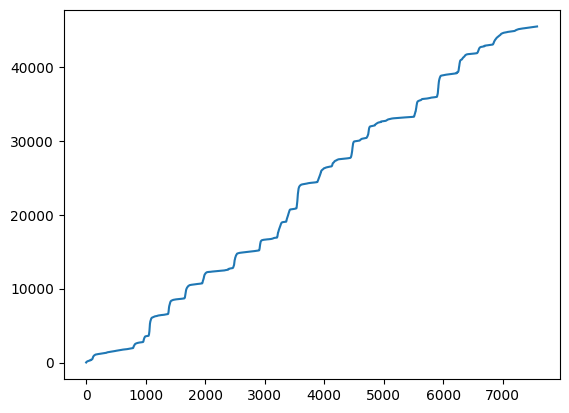

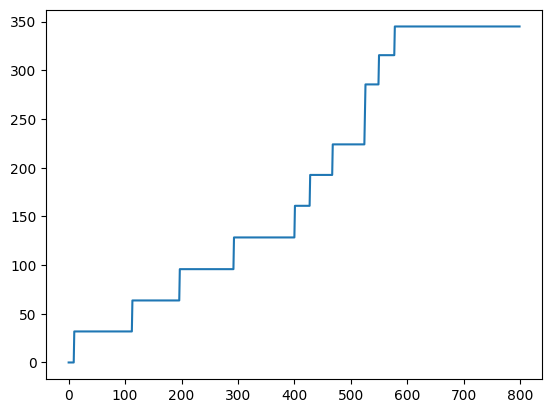

In [84]:
# ez gym
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
print("r = cummulative reward, l = length, t = time")


optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
loss_fn = torch.nn.SmoothL1Loss()
losses = []
rewards_epi = []


# memory
max_sequence_length = n_positions
states = deque(maxlen=max_sequence_length)
actions = deque(maxlen=max_sequence_length)
rewards = deque(maxlen=max_sequence_length)
times = deque(maxlen=max_sequence_length)


t = 0
observation, info = env.reset()
action = np.array([0 for _ in range(action_dim)]) # no reward for no action in the first step
reward = 0

games = 0
while games != 800:

    # add to memory
    states.append(observation)
    actions.append(action)
    rewards.append(reward)
    times.append(t)

    # act
    states_tensor = torch.tensor(states, device=device, dtype=torch.float32).reshape(1, len(states), 1)
    actions_tensor = torch.tensor(actions, device=device, dtype=torch.float32).reshape(1, len(actions), len(actions[0]))
    rewards_tensor = torch.tensor(rewards, device=device, dtype=torch.float32).reshape(1, len(rewards), 1)
    times_tensor = torch.tensor(times, device=device, dtype=torch.long).reshape(1, len(times))


    state_preds, action_preds, return_preds = model(states=states_tensor,rewards=rewards_tensor,timesteps=times_tensor,actions=actions_tensor)
    state_preds, action_preds, return_preds = torch.squeeze(state_preds, 0), torch.squeeze(action_preds, 0), torch.squeeze(return_preds, 0) # remove the batch dimension
    
    actionIndex = torch.argmax(action_preds[0]).item()
    if random.random() < 0.2:
        actionIndex = env.action_space.sample()
    
    action = np.zeros(action_dim)
    action[actionIndex] = 1

    # step
    t += 1
    observation, reward, terminated, truncated, info = env.step(actionIndex)


    # learn
    rewardLoss = loss_fn(return_preds[0], torch.tensor(reward, device=device, dtype=torch.float32))
    actionQLoss = loss_fn(action_preds[0][actionIndex], torch.tensor(reward, device=device, dtype=torch.float32))
    obsLoss = loss_fn(state_preds[0], torch.tensor(observation, device=device, dtype=torch.float32))



    # learn
    rewardLoss = loss_fn(return_preds[0], torch.tensor(reward, device=device, dtype=torch.float32))
    actionQLoss = loss_fn(action_preds[0][actionIndex], torch.tensor(reward, device=device, dtype=torch.float32))
    obsLoss = loss_fn(state_preds[0], torch.tensor(observation, device=device, dtype=torch.float32))

    loss = rewardLoss + actionQLoss + obsLoss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


    # if done
    if terminated or truncated:
        if (games % 100) == 0:
            print(info["episode"])
        rewards_epi.append(info["episode"]["r"])

        # reset memory here
        states.clear()
        actions.clear()
        rewards.clear()
        times.clear()

        t = 0
        observation, info = env.reset()

        games += 1


# plot
plt.plot(np.cumsum(losses))
plt.show()

plt.plot(np.cumsum(rewards_epi))
plt.show()

env.close()
